In [ ]:
# !pip install rasterio

In [ ]:
# !pip install sdd-segmentation
# from sdd_segmentation.sdd import sdd_threshold_selection

In [1]:
%%shell
wget -c https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
conda install -q -y --prefix /usr/local python=3.6 gdal

--2023-04-06 13:17:01--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M   149MB/s    in 0.4s    

2023-04-06 13:17:02 (149 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [59]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [60]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst


#FILENAME = r"orig_img.tif"

In [61]:
def show_image(image, path_to_save=None):
    f = plt.figure(figsize=(5, 5))  
    plt.imshow(image)
    plt.show()
    if path_to_save is not None:
        plt.imsave(f"{path_to_save}.png", image)  

In [62]:
def get_image_RGB(filename):
    image = gdal.Open(filename)
    # As, there are 3 bands, we will store in 3 different variables 
    band_1 = image.GetRasterBand(1) # red channel  
    band_2 = image.GetRasterBand(2) # green channel  
    band_3 = image.GetRasterBand(3) # blue channel   
    #band_4 = image.GetRasterBand(4) # alpha channel
    b1 = band_1.ReadAsArray()  
    b2 = band_2.ReadAsArray()  
    b3 = band_3.ReadAsArray()
    # b4 = band_4.ReadAsArray()
    # Normalize input image to range [0, 255]
    normalized_b1 = cv2.normalize(b1, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    normalized_b2 = cv2.normalize(b2, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)  
    normalized_b3 = cv2.normalize(b3, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    return np.dstack((normalized_b1, normalized_b2, normalized_b3))


In [63]:
# image_RGB = get_image_RGB("S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_15_08.tif")
# show_image(image_RGB)

In [64]:
def print_info_image(filename):
    image = gdal.Open(filename)
    image_arr = image.ReadAsArray()
    print(f'Image as array:', f'dtype: {image_arr.dtype}, shape: {image_arr.shape}, min: {np.min(image_arr)}, max: {np.max(image_arr)}')
    print("Driver: {}/{}".format(image.GetDriver().ShortName,
                                image.GetDriver().LongName))
    print("Size is {} x {} x {}".format(image.RasterXSize,
                                        image.RasterYSize,
                                        image.RasterCount))
    print("Projection is {}".format(image.GetProjection()))
    print("Metadata: {}".format(image.GetMetadata()))
    geotransform = image.GetGeoTransform()
    if geotransform:
        print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
        print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))
        

In [66]:
def otsu_method(image):
    # For debuging use cv2_imshow
    # Applying Otsu's method setting the flag value into cv.THRESH_OTSU.
    # Use a bimodal image as an input.
    # Optimal threshold value is determined automatically.
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # denoise the image with a Gaussian filter
    blurred_image = cv2.GaussianBlur(gray,(5,5),0)

    otsu_threshold, image_result = cv2.threshold(
        blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU,
    )

    # Remove noise and fill holes in the binary image using morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    closed = cv2.morphologyEx(image_result, cv2.MORPH_OPEN, kernel)

    return closed


def draw_contours(thresh, image):
    # Find the contours in the input image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Draw the contours on an image
    contour_img = cv2.drawContours(image, contours, -1, (0, 255, 0), 5)

    return contour_img

In [70]:
def connected_components(filename, connectivity=2, path_to_save=None):
    image = get_image_RGB(filename)
    # clone our original image (so we can draw on it) and then draw
    # a bounding box surrounding the connected component along with
    # a circle corresponding to the centroid
    output_image = image.copy()
    # convert the image to grayscale
    closed = otsu_method(image)

    # perform connected component analysis
    # apply connected component analysis to the thresholded image
    output = cv2.connectedComponentsWithStats(closed, connectivity, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    # initialize an output mask to store all forests parsed from
    # the image
    mask = np.zeros(image.shape, dtype="uint8")
    # loop over the number of unique connected component labels
    for i in range(1, numLabels):
      # extract the connected component statistics and centroid for
      # the current label
      x = stats[i, cv2.CC_STAT_LEFT]
      y = stats[i, cv2.CC_STAT_TOP]
      w = stats[i, cv2.CC_STAT_WIDTH]
      h = stats[i, cv2.CC_STAT_HEIGHT]
      area = stats[i, cv2.CC_STAT_AREA]
      # ensure the width, height, and area are all neither too small
      # nor too big
      keepWidth = w > 50
      keepHeight = h > 50
      keepArea = area > 250
      (cX, cY) = centroids[i]
      # ensure the connected component we are examining passes all
      # three tests
      if all((keepWidth, keepHeight, keepArea)):
        # if this is the first component then we examine the
        # *background* (typically we would just ignore this
        # component in our loop)
        print("Area: {}, Width: {}, Height: {}".format(area, w, h))
        if i == 0:
          text = "examining component {}/{} (background)".format(
            i + 1, numLabels)
        # otherwise, we are examining an actual connected component
        else:
          text = "examining component {}/{}".format( i + 1, numLabels)
        # print a status message update for the current connected
        # component
        print("[INFO] {}".format(text))
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 3)
        cv2.circle(output_image, (int(cX), int(cY)), 4, (0, 0, 255), -1)
    # show our output image and connected component mask
    show_image(output_image)
    if path_to_save is not None:
        plt.imsave(f"{path_to_save}.png", output_image)



In [71]:
# connected_components(FILENAME, connectivity=8) # sigma=2.0, 

In [72]:
def NDVI(image_file, t_pixel_forest=0.3, t_is_forest=0.5):
    ds = gdal.Open(image_file)
    red_band = ds.GetRasterBand(1).ReadAsArray().astype(np.float32)
    # If there is NIR_band on the second band we use NIR_band, if not, then we use green
    NIR_band = ds.GetRasterBand(4).ReadAsArray().astype(np.float32) 

    # calculate NDVI
    ndvi = (NIR_band - red_band) / (NIR_band + red_band)

    # classify pixels as forest or non-forest based on a threshold value
    forest_mask = np.where(ndvi >= t_pixel_forest, 1, 0)
    forest_percent = np.average(forest_mask)
    print(forest_percent)
    
    # classify the image based on the percentage of forest cover
    is_forest = True
    if forest_percent >= t_is_forest:
        print('The image contains a forest')
    else:
        is_forest = False
        print('The image does not contain a forest')

    return is_forest

# NDVI(r"test.tif")
# NDVI(FILENAME)

In [ ]:
def main(image_file):
  if NDVI(image_file):
    connected_components(image_file)
    show_image(draw_contours(otsu_method(get_image_RGB(image_file)), get_image_RGB(image_file)))
  else:
    show_image(get_image_RGB(image_file))

#main(r"test.tif")

In [ ]:
def spectral_signatures():
  pass

In [ ]:
def get_4_band(image_file):
    ds = gdal.Open(image_file)
    return ds.GetRasterBand(4).ReadAsArray().astype(np.float32)

#get_4_band(FILENAME)

In [114]:
# f = plt.figure(figsize=(10, 10)) 
# plt.hist(get_4_band(FILENAME)) 
# # plt.imshow(get_image_RGB(FILENAME))
# # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
# # cax = plt.axes(get_4_band(FILENAME))
# # plt.colorbar(cax=cax)
# plt.show() 


In [74]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.utils import class_weight

In [75]:


# Efficient net without augmentation4
class EfficientNetModel:
    metrics_names = ['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'prc']
    METRICS = [
          tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc'),
          tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]
    
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.base_model = tf.keras.applications.efficientnet.EfficientNetB2(input_shape=self.input_shape, include_top=False, weights='imagenet')
        self.data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomZoom(0.2),
            tf.keras.layers.RandomRotation(factor=0.15),
            tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
            tf.keras.layers.RandomContrast(factor=0.1),
            ],
            name="img_augmentation",
            )
        self.model = self.build_model()
        
    def build_model(self):
        inputs = tf.keras.layers.Input(shape=self.input_shape)
        x = self.data_augmentation(inputs)
        x = self.base_model(x)
        
        for layer in self.base_model.layers[:40]:  #-20
            # if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
                
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        predictions = tf.keras.layers.Dense(self.num_classes, activation='sigmoid')(x)  # !!
        model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
        return model

     
    def compile(self, learning_rate = 0.0001):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=self.METRICS)  
    
    def evaluate(self, data):
        return self.model.evaluate(data)
    
    def predict(self, data, verbose=None):
        return self.model.predict(data, verbose)
    
    def summary(self):
        return self.model.summary()
    
    def save_model(self, filepath):
        self.model.save(filepath)
        
    def load_model(self, model_path):
        self.model.load_weights(model_path)
        
    def plot_model_architecture(self, file_path):
        tf.keras.utils.plot_model(self, to_file=file_path, show_shapes=True)
        


In [76]:
# load the model
model = EfficientNetModel(input_shape=(64, 64, 3), num_classes=1)

model.load_model('efficientB2_model.h5')

# define the input image size
input_size = (64, 64)

S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_08_08.tif


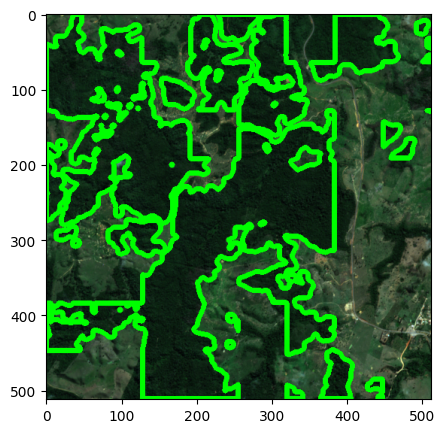

--------------------
S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_15_08.tif


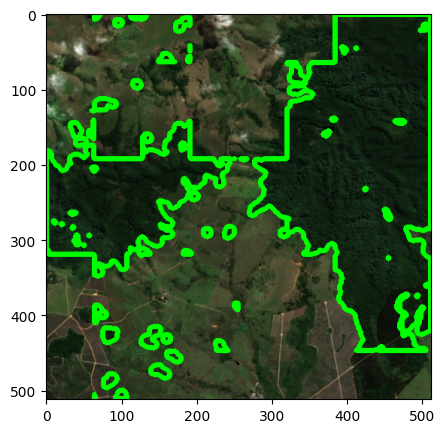

--------------------
S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_16_11.tif


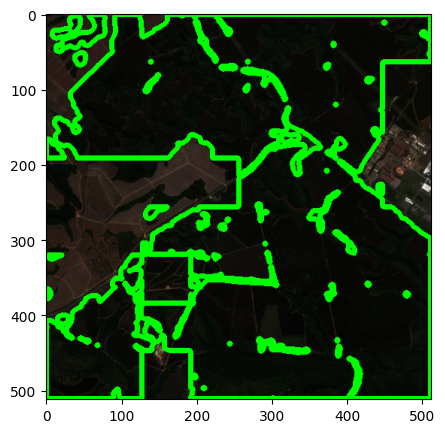

--------------------
S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_20_15.tif


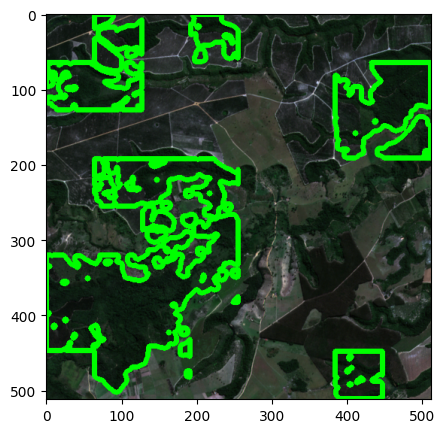

--------------------
S2A_MSIL2A_20191105T130251_N0213_R095_T23KQV_20191105T150708_01_21.tif


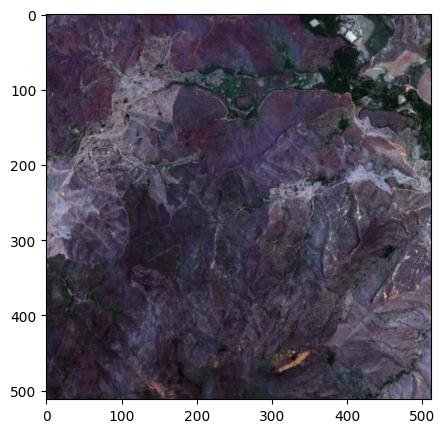

--------------------
S2A_MSIL2A_20191105T130251_N0213_R095_T23KQV_20191105T150708_08_09.tif


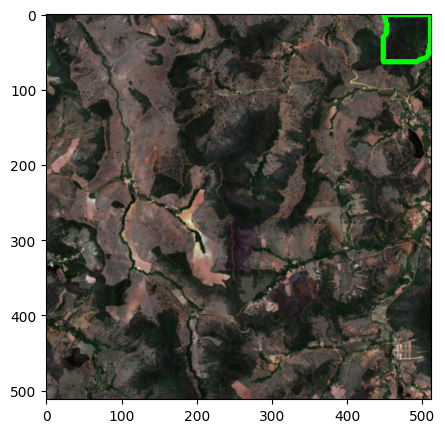

--------------------
S2A_MSIL2A_20191105T130251_N0213_R095_T23KQV_20191105T150708_14_07.tif


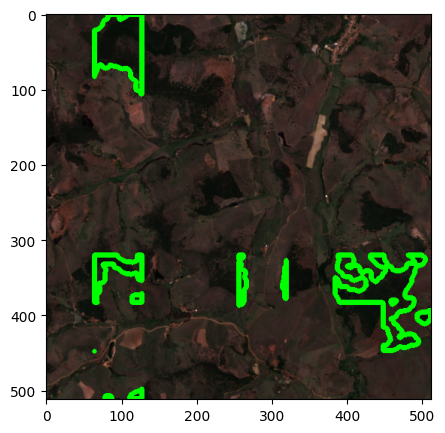

--------------------
S2A_MSIL2A_20191105T130251_N0213_R095_T23KQV_20191105T150708_18_02.tif


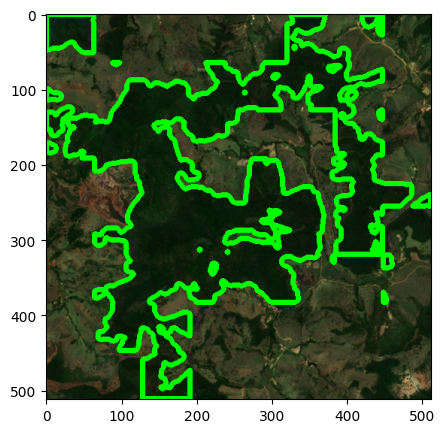

--------------------
S2A_MSIL2A_20191105T130251_N0213_R095_T23KQV_20191105T150708_20_13.tif


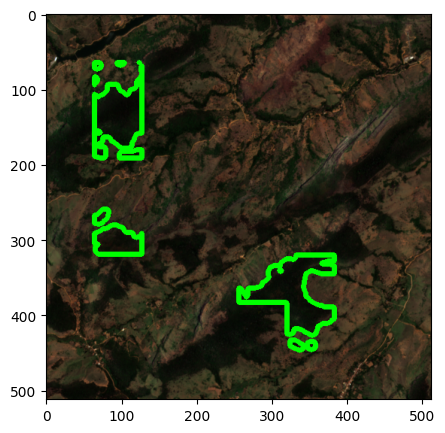

--------------------
S2A_MSIL2A_20200612T130251_N0214_R095_T23KQV_20200612T165421_01_18.tif


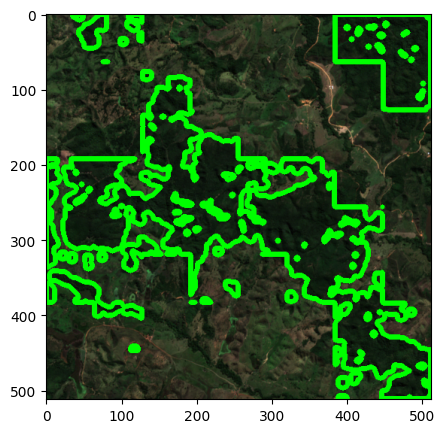

--------------------
S2A_MSIL2A_20200612T130251_N0214_R095_T23KQV_20200612T165421_04_06.tif


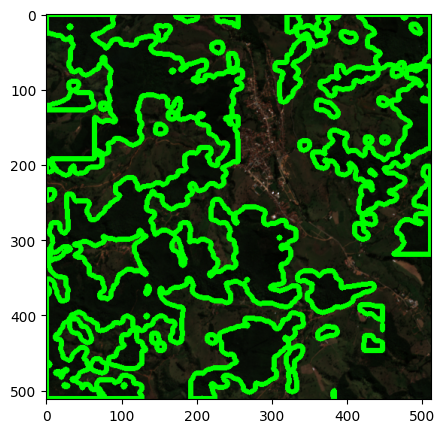

--------------------
S2A_MSIL2A_20200612T130251_N0214_R095_T23KQV_20200612T165421_13_19.tif


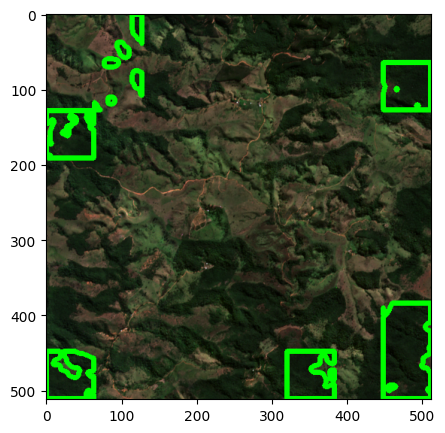

--------------------
S2A_MSIL2A_20200612T130251_N0214_R095_T23KQV_20200612T165421_14_20.tif


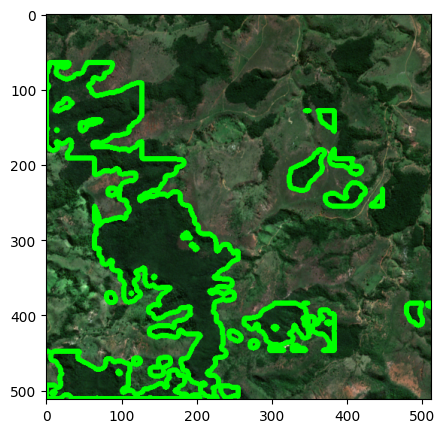

--------------------
S2A_MSIL2A_20200612T130251_N0214_R095_T23KQV_20200612T165421_15_18.tif


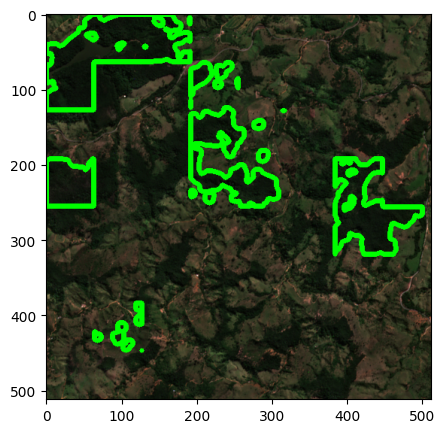

--------------------
S2A_MSIL2A_20200612T130251_N0214_R095_T23KQV_20200612T165421_16_01.tif


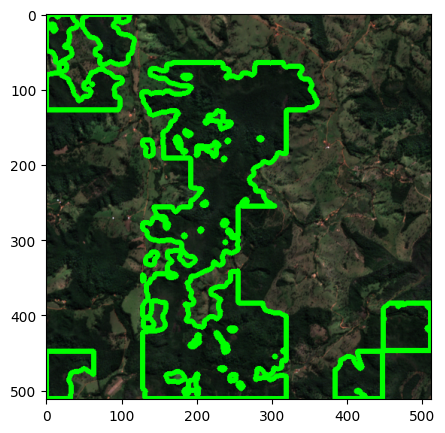

--------------------
S2A_MSIL2A_20200810T133231_N0214_R081_T22JCS_20200810T155345_06_15.tif


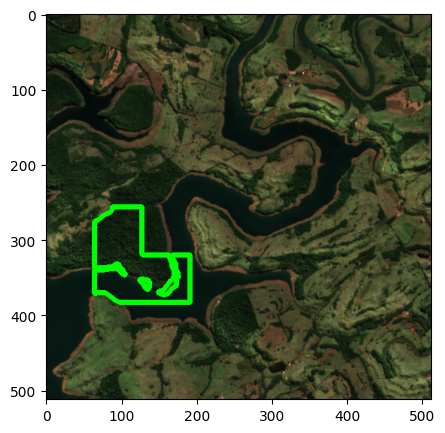

--------------------
S2A_MSIL2A_20200810T133231_N0214_R081_T22JCS_20200810T155345_06_10.tif


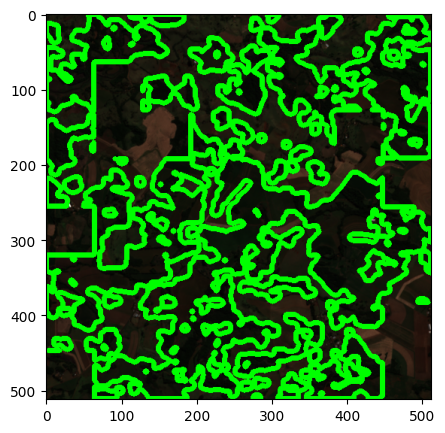

--------------------
S2B_MSIL2A_20191129T133219_N0213_R081_T22JCS_20191129T154507_08_17.tif


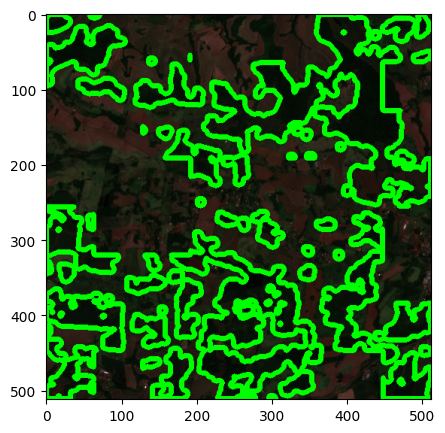

--------------------
S2B_MSIL2A_20191129T133219_N0213_R081_T22JCS_20191129T154507_09_02.tif


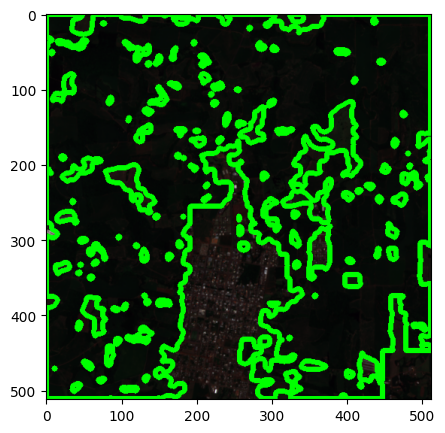

--------------------
S2B_MSIL2A_20191129T133219_N0213_R081_T22JCS_20191129T154507_16_07.tif


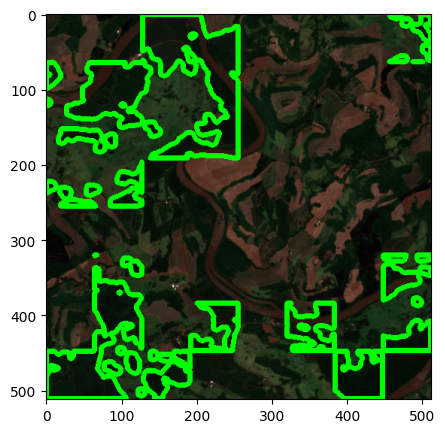

--------------------


In [111]:
tf.keras.utils.disable_interactive_logging()

def check_block_within_bounds(shape, block_size, lrx, lry, ulx, uly):
    x_shape, y_shape = shape[0], shape[1]

    if lrx > x_shape:
        lrx = x_shape
        ulx = lrx - block_size
    if lry > y_shape:
        lry = y_shape
        uly = lry - block_size
    
    return lrx, lry, ulx, uly

def predict_block(block, threshold):
    image = cv2.resize(block, input_size)
    image = image.astype('float32') / 255.0 

    prediction = model.predict(np.expand_dims(image, axis = 0))
    predicted_label = 1 if prediction.item() >= threshold else 0

    return predicted_label


def find_forest(filename):
    block_size = 64
    table_size = 8
    threshold = 0.25
    img = get_image_RGB(filename)

    binary_image = otsu_method(img)

    is_forest_table = np.zeros((table_size, table_size))
    
    # loop through each block and save as a separate JPEG file
    col = 0
    row = 0
    for i in range(0, img.shape[0], block_size):       
        for j in range(0, img.shape[1], block_size):  
            # calculate the pixel coordinates of the block
            ulx = i
            uly = j
            lrx = i + block_size
            lry = j + block_size

            # make sure the block is within the image bounds
            lrx, lry, ulx, uly = check_block_within_bounds(img.shape, 
                                                           block_size,
                                                           lrx, 
                                                           lry, 
                                                           ulx,
                                                           uly)

            block = img[ulx:lrx, uly:lry, :]

            predicted_label = predict_block(block, threshold)
            is_forest_table[col, row] = predicted_label
            row += 1
        col += 1
        row = 0
    # print(is_forest_table)

    for i in range(1, is_forest_table.shape[0] - 1):
        for j in range(1, is_forest_table.shape[1] - 1):
            
            current_predict = is_forest_table[i, j]

            if current_predict == 0:
                continue

            up_predict = is_forest_table[i-1, j]
            down_predict = is_forest_table[i+1, j]
            left_predict = is_forest_table[i, j-1]
            right_predict = is_forest_table[i, j+1]
            ulx = i * block_size
            uly = j * block_size
            lrx = i * block_size + block_size
            lry = j * block_size + block_size

            if right_predict == 0:
                block = img[ulx:lrx, uly + 32:lry + 32, :]
                is_forest_table[i, j+1] = predict_block(block, threshold)
                
            if left_predict == 0:
                block = img[ulx:lrx, uly - 32:lry - 32, :]
                # print("Left")
                # show_image(block)
                is_forest_table[i, j-1] = predict_block(block, threshold)

            if up_predict == 0:
                block = img[ulx-32:lrx-32, uly:lry, :]
                # print("Up")
                # show_image(block)
                is_forest_table[i-1, j] = predict_block(block, threshold)

            if down_predict == 0:
                block = img[ulx+32:lrx+32, uly:lry, :]
                # print("Down")
                # show_image(block)
                is_forest_table[i+1, j] = predict_block(block, threshold)
            
    # расматриваем частный случай на краях:
    top_left = is_forest_table[0, 0]
    if top_left == 0:
        block_right = img[0:block_size, 32:block_size + 32, :]
        block_down = img[32:block_size + 32, 0:block_size, :]
        if predict_block(block_right, threshold) or predict_block(block_down, threshold):
            is_forest_table[0, 0] = 1

    top_right = is_forest_table[0, 1]
    if top_right == 0:
        block_left = img[0:block_size, img.shape[1] - block_size - 32:img.shape[1] - 32, :]
        block_down = img[32:block_size + 32, img.shape[1] - block_size:img.shape[1], :]
        
        if predict_block(block_left, threshold) or predict_block(block_down, threshold):
            is_forest_table[0, 1] = 1

    down_left = is_forest_table[1, 0]
    if down_left == 0:
        block_up = img[img.shape[0] - block_size - 32:img.shape[0] - 32, 0:block_size, :]
        block_right = img[img.shape[0] - block_size:img.shape[0], 32:block_size + 32, :]

        if predict_block(block_up, threshold) or predict_block(block_right, threshold):
            is_forest_table[1, 0] = 1

    down_right = is_forest_table[1, 1]
    if down_right == 0:
        block_left = img[img.shape[0] - block_size:img.shape[0], img.shape[1] - block_size - 32:img.shape[1]-32, :]
        block_up = img[img.shape[0] - block_size-32:img.shape[0]-32, img.shape[1] - block_size:img.shape[1], :]
        if predict_block(block_left, threshold) or predict_block(block_up, threshold):
            is_forest_table[1, 1] = 1

    #print(is_forest_table)
    col = 0
    row = 0
    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            # calculate the pixel coordinates of the block
            ulx = i
            uly = j
            lrx = i + block_size
            lry = j + block_size
            # make sure the block is within the image bounds
            lrx, lry, ulx, uly = check_block_within_bounds(img.shape,
                                                           block_size,
                                                           lrx, 
                                                           lry, 
                                                           ulx, 
                                                           uly)

            if is_forest_table[col, row] == 0:
                binary_image[ulx:lrx, uly:lry] = 0
            row += 1
        col += 1
        row = 0

    img_with_contours = draw_contours(binary_image, img)

    return img_with_contours


def look_all_files(folder_path, path_to_save, main_t=0.5):
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            print(filename)
            
            FILENAME = os.path.join(root, filename)
            image = find_forest(FILENAME)
            show_image(image, path_to_save=os.path.join(path_to_save, filename))
            # if filename == "S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_15_08.tif":

            #     FILENAME = os.path.join(root, filename)
            #     image = find_forest(FILENAME)
            #     show_image(image, path_to_save=os.path.join(path_to_save, filename))
            print("-"*20)

# # Установите имя и путь к папке
folder_name = 'contours_for_forest/'
path_to_save = '/content/' + folder_name 

# Создайте новую папку, если она не существует
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)



look_all_files('/content/drive/MyDrive/test_forest', path_to_save, main_t=0.3)

In [113]:
import shutil
import os

# Установите имя и путь к папке, которую нужно удалить
folder_name = 'contours_for_forest'
path = '/content/' + folder_name

# Удалите папку, если она существует
if os.path.exists(path):
    shutil.rmtree(path)
    print('Папка удалена:', path)
else:
    print('Папка не существует:', path)


Папка удалена: /content/contours_for_forest


In [112]:
!zip -r contours_for_forest.zip  '/content/contours_for_forest/'

  adding: content/contours_for_forest/ (stored 0%)
  adding: content/contours_for_forest/S2A_MSIL2A_20191105T130251_N0213_R095_T23KQV_20191105T150708_08_09.tif.png (deflated 0%)
  adding: content/contours_for_forest/S2A_MSIL2A_20191105T130251_N0213_R095_T23KQV_20191105T150708_01_21.tif.png (deflated 0%)
  adding: content/contours_for_forest/S2A_MSIL2A_20200612T130251_N0214_R095_T23KQV_20200612T165421_04_06.tif.png (deflated 0%)
  adding: content/contours_for_forest/S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_15_08.tif.png (deflated 0%)
  adding: content/contours_for_forest/S2A_MSIL2A_20191105T130251_N0213_R095_T23KQV_20191105T150708_14_07.tif.png (deflated 0%)
  adding: content/contours_for_forest/S2A_MSIL2A_20200612T130251_N0214_R095_T23KQV_20200612T165421_16_01.tif.png (deflated 0%)
  adding: content/contours_for_forest/S2A_MSIL2A_20190715T125311_N0213_R052_T24LVH_20190715T150206_20_15.tif.png (deflated 0%)
  adding: content/contours_for_forest/S2A_MSIL2A_20191105T13

In [18]:
# def find_forest(filename):
#     block_size = 64
#     threshold = 0.25
#     # read the input GeoTIFF file
#     img = get_image_RGB(filename)

#     binary_image = otsu_method(img)
#     #show_image(binary_image)
#     list_to_delete = []
#     # loop through each block and save as a separate JPEG file
#     for i in range(0, img.shape[1], block_size):
#         for j in range(0, img.shape[0], block_size):
#             flag_hor = False
#             # calculate the pixel coordinates of the block
#             ulx = i
#             uly = j
#             lrx = i + block_size
#             lry = j + block_size

#             # make sure the block is within the image bounds
#             if lrx > img.shape[0]:
#                 lrx = img.shape[0]
#                 ulx = lrx - block_size
#             if lry > img.shape[1]:
#                 lry = img.shape[1]
#                 uly = lry - block_size

#             block = img[ulx:lrx, uly:lry, :]

#             # show_image(block)

#             image = cv2.resize(block, input_size)
#             image = image.astype('float32') / 255.0 

#             prediction = model.predict(np.expand_dims(image, axis = 0))
#             predicted_label = 1 if prediction.item() >= threshold else 0
#             predicted_label_vert = predicted_label

#             # 1 - 0
#             if predicted_label == 0:
#                 #print(binary_image[ulx:lrx, uly:lry])
#                 #print()
#                 if ulx-64 >= 0 and lrx-64 >= 0:
#                   if [ulx-64, lrx-64, uly, lry] not in list_to_delete:
#                       block = img[ulx-32:lrx-32, uly:lry, :]

#                       image = cv2.resize(block, input_size)
#                       image = image.astype('float32') / 255.0 

#                       prediction = model.predict(np.expand_dims(image, axis = 0))
#                       predicted_label = 1 if prediction.item() >= threshold - 0.2 else 0
                
#                 if predicted_label == 0 and [ulx, lrx, uly, lry] not in list_to_delete:
#                     list_to_delete.append([ulx, lrx, uly, lry])
#                 else:
#                   flag_hor = True
                    
#             # 0 - 1
#             elif predicted_label == 1:
#                 #print(binary_image[ulx:lrx, uly:lry])
#                 #print()
#                 if ulx-64 >= 0 and lrx-64 >= 0:
#                   if [ulx-64, lrx-64, uly, lry] in list_to_delete:
#                       block = img[ulx-32:lrx-32, uly:lry, :]

#                       image = cv2.resize(block, input_size)
#                       image = image.astype('float32') / 255.0 

#                       prediction = model.predict(np.expand_dims(image, axis = 0))
#                       predicted_label = 1 if prediction.item() >= threshold - 0.2 else 0
                
#                 if predicted_label == 1 and [ulx, lrx, uly, lry] in list_to_delete:
#                     list_to_delete.remove([ulx-64, lrx-64, uly, lry])
                    
#                     # flag = True
#                     #binary_image[ulx:lrx, uly:lry] = 0
            
#             # vertical
#             if predicted_label_vert == 0:
#                 if uly-64 >= 0 and lry-64 >= 0:
#                   if [ulx, lrx, uly-64, lry-64] not in list_to_delete:
#                       block = img[ulx:lrx, uly-32:lry-32, :]

#                       image = cv2.resize(block, input_size)
#                       image = image.astype('float32') / 255.0 

#                       prediction = model.predict(np.expand_dims(image, axis = 0))
#                       predicted_label = 1 if prediction.item() >= threshold - 0.2 else 0
#                 if predicted_label == 0 and [ulx, lrx, uly, lry] not in list_to_delete and not flag_hor:
#                     list_to_delete.append([ulx, lrx, uly, lry])
              
#             elif predicted_label_vert == 1:
#                 if uly-64 >= 0 and lry-64 >= 0:
#                   if [ulx, lrx, uly-64, lry-64] in list_to_delete:
#                       block = img[ulx:lrx, uly-32:lry-32, :]

#                       image = cv2.resize(block, input_size)
#                       image = image.astype('float32') / 255.0 

#                       prediction = model.predict(np.expand_dims(image, axis = 0))
#                       predicted_label = 1 if prediction.item() >= threshold - 0.2 else 0

#                 if predicted_label == 1 and [ulx, lrx, uly, lry] in list_to_delete:
#                     list_to_delete.remove([ulx, lrx, uly-64, lry-64])

#     for ulx, lrx, uly, lry in list_to_delete:
#         binary_image[ulx:lrx, uly:lry] = 0
#     img_with_contours = draw_contours(binary_image, img)
    

#     return img_with_contours

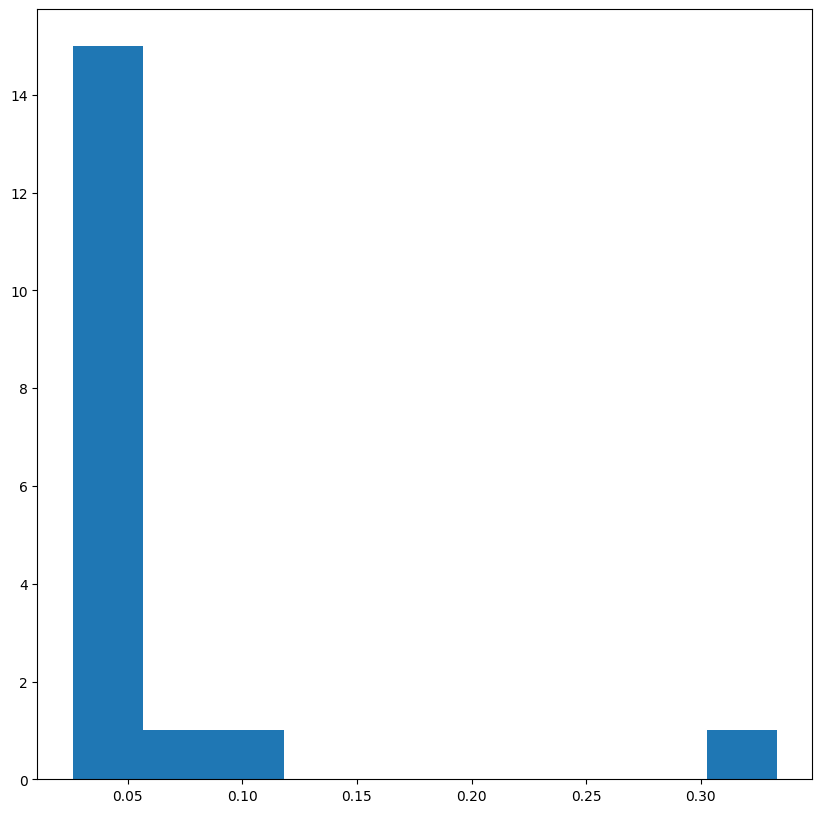

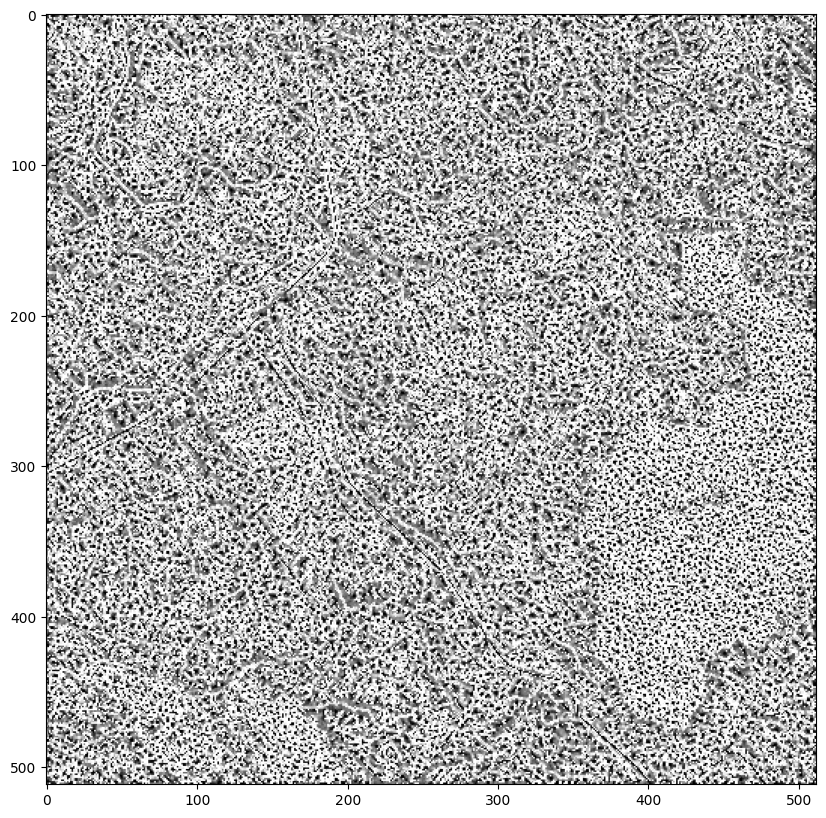

In [ ]:
from skimage import feature
import numpy as np


class LocalBinaryPatterns:
    def __init__(self, image, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.lbp = feature.local_binary_pattern(gray, self.numPoints,
          self.radius, method="uniform")


    def describe(self, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        
        (hist, _) = np.histogram(self.lbp.ravel(),
          bins=np.arange(0, self.numPoints + 3),
          range=(0, self.numPoints + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return hist
    
    def show_hist(self):
        f = plt.figure(figsize=(10, 10)) 
        plt.hist(self.describe()) 
        plt.show()
    
    def show_texture_image(self):
        f = plt.figure(figsize=(10, 10)) 
        plt.imshow(self.lbp.astype("uint8"), cmap="gray") 
        plt.show() 



def texture_analysis(r, n_points):
    radius = 2
    n_points = 8 * radius 
    lbp = LocalBinaryPatterns(get_image_RGB(FILENAME), n_points, radius)
    lbp.show_hist()
    lbp.show_texture_image()




radius = 2
n_points = 8 * radius
texture_analysis(radius, n_points)